# ADSP 32014 Final Project

### Setup

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pymc as pm
#import aesara.tensor as at
import arviz as az

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error

import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the data
user_artists = pd.read_csv('./Data/user_artists.dat', sep='\t',
                           names=['userID', 'artistID', 'listen_count'], skiprows=1)
artists = pd.read_csv('./Data/artists.dat', sep='\t',
                      names=['artistID', 'name', 'url', 'pictureURL'],
                      encoding='latin-1', skiprows=1)

### EDA

#### Artists Data

In [3]:
artists.head()

,artistID,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


#### User/Artist Data

In [4]:
# Check the user/artist file
user_artists.head()

,userID,artistID,listen_count
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [5]:
# Check the dimensions
print(f'User/artists dimensions: {user_artists.shape}')

# Check the minimum and maximum of the listen_count
print(f'Minimum number of listens: {user_artists.listen_count.min()}')
print(f'Maximum number of listens: {user_artists.listen_count.max()}')

User/artists dimensions: (92834, 3)
Minimum number of listens: 1
Maximum number of listens: 352698


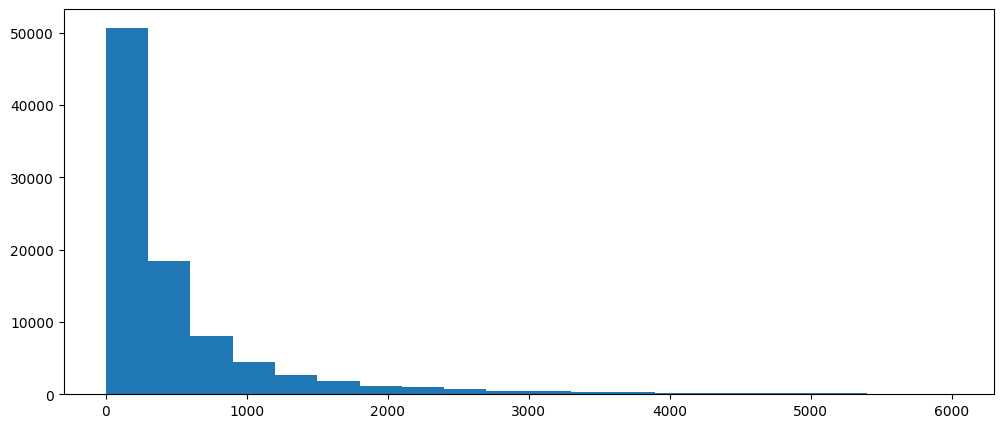

In [6]:
# Check the distribution of the number of listens
plt.figure(figsize = (12,5))
plt.hist(user_artists[user_artists['listen_count'] < 6000]['listen_count'], bins = 20)
plt.show()

In [7]:
ua = user_artists.merge(artists[['artistID', 'name']], on='artistID', how='left')

top_artists = ua.groupby('name')['listen_count'].sum().sort_values(ascending=False).head(20).reset_index()

top_artists

,name,listen_count
0,Britney Spears,2393140
1,Depeche Mode,1301308
2,Lady Gaga,1291387
3,Christina Aguilera,1058405
4,Paramore,963449
5,Madonna,921198
6,Rihanna,905423
7,Shakira,688529
8,The Beatles,662116
9,Katy Perry,532545


### Data Preparation

In [11]:
# Map user and artist IDs to indices
u_id = user_artists['userID'].unique()
a_id = user_artists['artistID'].unique()
user_map = {u: i for i, u in enumerate(u_id)}
artist_map = {a: i for i, a in enumerate(a_id)}

# Create index columns
user_artists['u_idx'] = user_artists['userID'].map(user_map)
user_artists['a_idx'] = user_artists['artistID'].map(artist_map)

# Log-transform the weights to reduce skew
user_artists['log_count'] = np.log1p(user_artists['listen_count'])

# Prepare arrays for modeling
u_idx = user_artists['u_idx'].values
a_idx = user_artists['a_idx'].values
count = user_artists['listen_count'].values
log_count = user_artists['log_count'].values

In [33]:
# Split indices for train/test
train_idx, test_idx = train_test_split(
    np.arange(len(count)), test_size=0.2, random_state=42
)

# Training data
train_u_idx = u_idx[train_idx]
train_a_idx = a_idx[train_idx]
train_count = count[train_idx]
train_log_count = log_count[train_idx]

# Test data
test_u_idx = u_idx[test_idx]
test_a_idx = a_idx[test_idx]
test_count = count[test_idx]
test_log_count = log_count[test_idx]


In [14]:
# Confirm the dimensions of the train/test are as expected
print(f'Training length: {long_train.shape[0]}')
print(f'Test length: {long_test.shape[0]}')

Training length: 1187621
Test length: 297367


### Train Model

In [45]:
# Check for overdispersion in the count data
mean = count.mean()
var = count.var()

print(f'Mean: {mean}')
print(f'Variance: {var}')

Mean: 745.2439300256372
Variance: 14072265.763914132


I compare the mean and variance to test for overdispersion because the Poisson distribution has $\mu = \sigma$. Because there is overdispersion, using a Poisson likelihood is not realistic. I use a begative binomial likelihood instead, which is more computationally intensive.

In [40]:
# Define the number of latent variables and the dimensions of U and V
n_latent = 5
n_users = len(u_id)
n_artists = len(a_id)

with pm.Model() as bpmf_advi:
    # Hyperpriors
    mu_u = pm.Normal('mu_u', mu=0, sigma=1, shape=n_latent)
    mu_v = pm.Normal('mu_v', mu=0, sigma=1, shape=n_latent)
    sigma_u = pm.HalfNormal('sigma_u', sigma=1)
    sigma_v = pm.HalfNormal('sigma_v', sigma=1)

    # Create U and V latent factors
    U = pm.Normal('U', mu = mu_u, sigma=sigma_u, shape=(n_users, n_latent))
    V = pm.Normal('V', mu = mu_u, sigma=sigma_u, shape=(n_artists, n_latent))
    
    # Observation noise
    alpha = pm.HalfNormal('alpha', sigma=1)

    # Dot product predicted ratings
    mu = pm.math.sum(U[u_idx] * V[a_idx], axis=1)

    # Likelihood - using negative so that we do not have to distort the value of 0 listens by logging
    R_obs = pm.NegativeBinomial('R_obs', mu=pm.math.exp(mu), alpha=alpha, observed=count)

    # Approximate the posterior
    approx = pm.fit(n=50000, method='advi')

    # Draw samples from the posterior
    trace_advi = approx.sample(draws=1000)

    # ELBO history
    elbos = approx.hist

Output()

Finished [100%]: Average Loss = 6.5128e+05


In [20]:
az.to_netcdf(trace_advi, 'nb_trace_nz_5k.nc')

'nb_trace_nz.nc'

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


KeyboardInterrupt: 

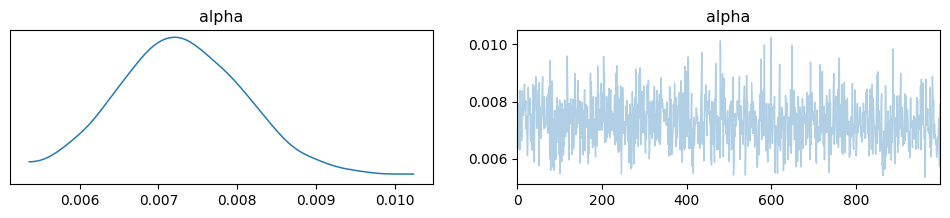

In [23]:
az.plot_trace(trace_advi, var_names=['alpha'])
az.summary(trace_advi, var_names=['alpha','U','V'])

In [44]:
# Use posterior means for prediction
posterior_U = trace_advi.posterior['U'].mean(dim=("chain", "draw")).values
posterior_V = trace_advi.posterior['V'].mean(dim=("chain", "draw")).values

# Predict test ratings
mu_hat = np.sum(posterior_U[test_u_idx] * posterior_V[test_a_idx], axis=1)
mu_hat_log = np.log1p(mu_hat)


# Compute error metrics
rmse = root_mean_squared_error(test_log_count, mu_hat_log)
mse = mean_squared_error(test_log_count, mu_hat_log)
mae = mean_absolute_error(test_log_count, mu_hat_log)

# Print error metrics
print(f'Test MSE: {mse:.4f}')
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")

Test MSE: 14.5297
Test RMSE: 3.8118
Test MAE: 3.5893


In [35]:
mu_hat

array([4.97399315, 6.56874441, 5.33841866, ..., 6.68581669, 7.67640077,
       8.38173328])

In [ ]:
!git co

In [46]:
!git commit -m "adding NB ADVI model"

Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: empty ident name (for <prnash_spr25@instance-20250524-183024.us-central1-c.c.abiding-aspect-460715-g4.internal>) not allowed
